# Sistema masa resorte amortiguador

## Ecuaciones de movimiento

Supongamos que el resorte no cumple la ley de Hook, sino que produce una fuerza que es:

$$f_k = Kx^3$$


Entonces las ecuaciones de movimiento son

$$ ma(t) = F+mg - f_b - f_k \implies m \ddot x(t) = F + mg - b \dot x(t) - K x^3(t)$$


Podemos escribir las ecuaciones de estado, suponiedo los estados son $\dot x = x_1$ y $x = x_2$. Entonces resultan:
$$
\begin{equation}
     \label{eq:aqui-le-mostramos-como-hacerle-la-llave-grande}
      \left\{
	       \begin{array}{ll}
		 \dot x_1(t) =     & -\dfrac{b}{m} x_1(t) - \dfrac{K}{m} x_2^3(t) +\dfrac{F(t)}{m} + g\\
		 \dot x_2(t) =  & x_1(t)
	       \end{array}
	     \right.
   \end{equation}
$$


El objetivo es linealizar el sistema en torno al punto de operación. Vamos a obtener el punto de operación para $F=0$.

Usaremos para este trabajo sympy para que nos ayude con la matemáticasimbólica.

## Sympy para la linealización

In [2]:
import sympy as sp
sp.init_printing()

In [3]:
F, m,  g, K, b, x1, x2 = sp.symbols('F, m,  g, K, b, x1, x2')

In [4]:
dx1 = -b/m*x1-K/m*x2**3+F/m+g
dx2 = x1

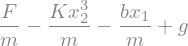

In [5]:
dx1

In [6]:
ec_est=sp.Matrix([dx1,dx2])
x=sp.Matrix([x1,x2])
u = sp.Matrix([F])

In [7]:
A = ec_est.jacobian(x)
B = ec_est.jacobian(u)

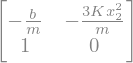

In [8]:
A

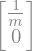

In [9]:
B

Para obtener el punto de equilibrio tenemos que igualar las derivadas $\dot x_1$ y $\dot x_2$ a 0 (el sistema este quieto). Vamos a considerar en un primer momento $F=0$

In [10]:
ec_est_f0 = ec_est.subs([(F,0)]) 
sol0 = sp.solve(ec_est_f0,(x1,x2),dict=True)

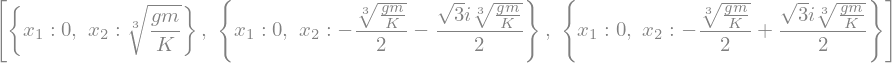

In [11]:
sol0

In [12]:
sol0 = sol0[0]

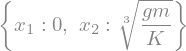

In [13]:
sol0

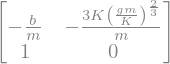

In [14]:
A.subs(sol0)

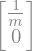

In [15]:
B.subs(sol0)

Podemos resolver también ahora si ponemos una $F=1$

In [16]:
ec_est_f1 = ec_est.subs([(F,1)]) 
sol1 = sp.solve(ec_est_f1,(x1,x2),dict=True)

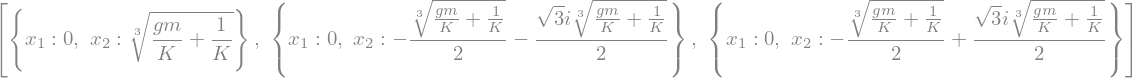

In [17]:
sol1

Me quedo con la única solución real posible que es la primera (recodar que python indexa de 0).

In [18]:
sol1 = sol1[0]

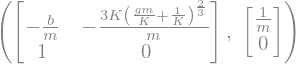

In [19]:
A.subs(sol1), B.subs(sol1) 

Podemos finalmente pasar a número e implementar con el paquete de control.

In [20]:
An=A.subs(sol1).subs([(b,1),(K,2),(m,3),(g,9.8)])

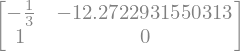

In [21]:
An

In [22]:
Bn=B.subs(sol1).subs([(b,1),(K,2),(m,3),(g,9.8)])

In [23]:
Bn

Analicemos un poco que son Bn y An

In [24]:
type(An)

sympy.matrices.dense.MutableDenseMatrix

Esto nos dice que es un objeto de tipo simbólico. Para poder usarlo debemos pasarlo a un tipo númerico.

## Utilización numérica de los resultados simbólicos

In [25]:
import numpy as np
import control as ctrl
import matplotlib.pyplot as plt
%matplotlib qt5

In [26]:
A1 = np.float64(An)
B1 = np.float64(Bn)

In [27]:
sys = ctrl.ss(A1,B1,[0,1],0)

In [28]:
t,y = ctrl.step_response(sys, T=np.linspace(0,40,1000))

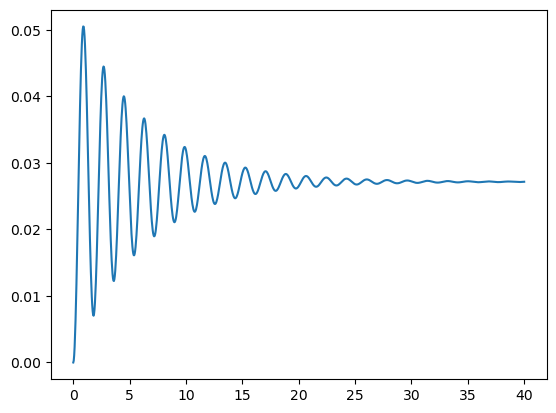

In [29]:
plt.figure()
plt.plot(t,y)
plt.gcf()

## Simulación No-Lineal

Primero debemos definir el sistema no lineal en un a función para que después podamos integrarlo con los métodos de integración del paquete scipy.

In [30]:
def resorte_no_lineal(t, x, b=1, m=3, K=2, g=9.8, step_amp=1):
    F=1+step_amp # Hacemos la entrada igual a 2 ya que al sistema lineal le aplicamos un escalón unitario sobre el punto de trabajo que era F=1
    x1,x2 = x
    dx1 = -b/m*x1-K/m*x2**3+F/m+g
    dx2 = x1
    return dx1, dx2

Para comenzar necesitamos también los valores númericos de las condiciones iniciales

In [31]:
x0 = np.float64(sol1[x1].subs([(b,1),(K,2),(m,3),(g,9.8)])), np.float64(sol1[x2].subs([(b,1),(K,2),(m,3),(g,9.8)]))

In [32]:
x0

In [33]:
import scipy.integrate as integ
tspan = (0, 40)
t1= np.linspace(*tspan, 1000)

def simulate():
    r = integ.solve_ivp(resorte_no_lineal, tspan, x0, t_eval=t1)
    return r.y

x1,x2=simulate()

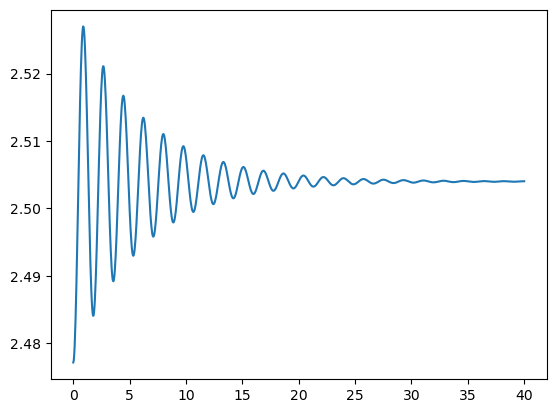

In [34]:
plt.figure()
plt.plot(t1,x2)
plt.gcf()

Para poder evaluar las diferencias me falta agregarle a la salida del sistema lineal el valor de equilibrio.

In [35]:
yc = y+x0[1]

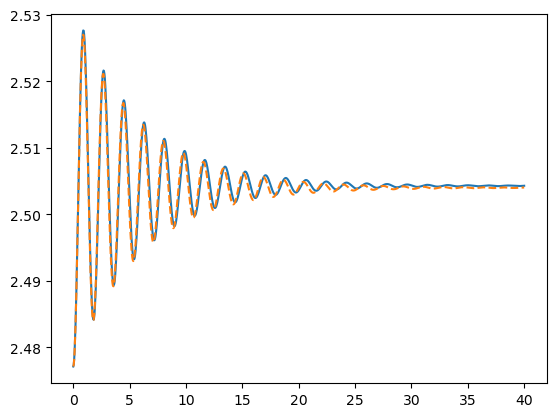

In [36]:
plt.figure()
plt.plot(t,yc,t1,x2,'--')
plt.gcf()